# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [1]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

# Librairies scikit-learn
from sklearn.model_selection import (
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non
from utils import generate_full_model_evaluation

### On reprend les éléments du notebook de l'étape 1

In [2]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape1_clean.csv")

# Partie 5 - Optimisez et interprétez le comportement du modèle

### Recommandation 1 - Reprenez les mêmes principes que le projet 3 (si vous suivez ce parcours dans sa totalité) pour le fine-tuning.
* Afin de trouver les meilleurs hyperparamètres de notre modèle sélectionné, CatBoost, nous utilisons un GridSearchCV pour les rechercher.

#### Récupération de notre séparation X et y et de nos features

In [3]:
# Transformation + séparation X et y dans utils.py
X, y = prepare_xy(donnees_modelisation, target_col="a_quitte_l_entreprise")
features_a_scaler, features_encodees = scaler_ou_non()

# Récupération des informations
train_data_df = pd.read_csv("../Data/Processed/train_data_df.csv")
test_data_df  = pd.read_csv("../Data/Processed/test_data_df.csv")

target_col = "a_quitte_l_entreprise"
X_train = train_data_df.drop(columns=[target_col])
y_train = train_data_df[target_col]
X_test  = test_data_df.drop(columns=[target_col])
y_test  = test_data_df[target_col]

#### Recherche des hyperparamètres via la fonction GridSearchCV

In [4]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),features_a_scaler),
        ('cat','passthrough',features_encodees)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',CatBoostClassifier(random_state = 42, verbose=0))
])
# Enregistrement des paramètres
param_grid = {
    'model__iterations' : [50, 100, 200, 600],
    'model__depth' : [1, 2],
    'model__learning_rate' : [0.01],
    'model__class_weights' : [[1, 3],[1, 5]],
}
# Mise en place du GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    scoring='balanced_accuracy', #choix du balanced_accuracy
    verbose = 0
)
# Entraînement du modèle
grid_search.fit(X_train, y_train)
# J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur balanced_accuracy :", grid_search.best_score_)

Meilleurs paramètres : {'model__class_weights': [1, 5], 'model__depth': 2, 'model__iterations': 600, 'model__learning_rate': 0.01}
Meilleur balanced_accuracy : 0.7395047370559825


#### Résultats du GridSearchCV

Les meilleurs paramètres sont :
* 'model__class_weights': [1, 5]
* 'model__depth': 2
* 'model__iterations': 600
* 'model__learning_rate': 0.01

### On peut désormais lancer une validation croisée avec nos nouveaux hyperparamètres optimisés 

In [5]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=600, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.01, # vitesse d’apprentissage
        class_weights=[1, 5], # pondération des classes
        random_state=42,
        verbose=0
    ))])

# Validation croisée sur l'entraînement (stockage moyennes/écarts-types)
scoring = ['precision', 'recall', 'f1', 'average_precision', 'balanced_accuracy']  # average_precision = PR AUC
cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1)

print("=== Résultats CV (train vs val) ===")
for metric in scoring:
    tr = cv_results[f"train_{metric}"]
    te = cv_results[f"test_{metric}"]
    print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

=== Résultats CV (train vs val) ===
precision         : train 0.482 ± 0.016 vs val 0.402 ± 0.047
recall            : train 0.792 ± 0.027 vs val 0.679 ± 0.022
f1                : train 0.599 ± 0.019 vs val 0.504 ± 0.043
average_precision : train 0.737 ± 0.033 vs val 0.588 ± 0.039
balanced_accuracy : train 0.814 ± 0.015 vs val 0.741 ± 0.027


#### On note principalement une augmentation de notre recall par rapport à la précédente GridSearchCV, on passe de 0.66 à 0.68 sur la partie validation. Cela correspond bien au seuil que nous voulons augmenter.

#### On entraîne et on évalue le modèle

In [6]:
# On entrâine le modèle
pipeline.fit(X_train, y_train)
# Évaluation TEST
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print("=== Classification Report - TRAIN ===")
print(classification_report(y_train, y_pred_train, digits=2))
print("=== Classification Report - TEST ===")
print(classification_report(y_test, y_pred_test, digits=2))

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       986
           1       0.45      0.75      0.56       190

    accuracy                           0.81      1176
   macro avg       0.70      0.79      0.72      1176
weighted avg       0.86      0.81      0.83      1176

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       247
           1       0.38      0.66      0.48        47

    accuracy                           0.77       294
   macro avg       0.65      0.73      0.67       294
weighted avg       0.84      0.77      0.79       294



#### Concernant l'évaluation sur le test final, on améliore les résultats sur le recall de la classe 0 par rapport à l'étape précédente de 0.77 à 0.79. On gagne également un peu de précision sur le recall de la classe 1.

### Afin de retrouver notre seuil optimal, on utilise le calcul fbeta afin de mettre l'accent sur le recall
* On le calcul sur nos données de train

In [7]:
proba_train = pipeline.predict_proba(X_train)[:, 1]

prec_tr, rec_tr, thr_tr = precision_recall_curve(y_train, proba_train)
# Création du seuil fbeta
beta = 2 # afin de mettre des poids supplémentaires sur le recall
f_beta = (1 + beta**2) * (prec_tr * rec_tr) / (beta**2 * prec_tr + rec_tr)
idx = int(np.nanargmax(f_beta))
best_thr = float(thr_tr[idx])
print(f"Notre seuil optimal fbeta est de {best_thr:.3f}")

Notre seuil optimal fbeta est de 0.453


#### Histogramme des probabilités + calcul de proba_test

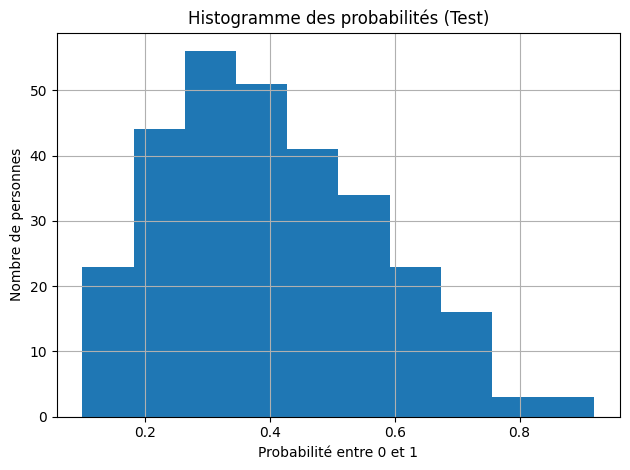

In [8]:
# Calcul de proba_test
proba_test = pipeline.predict_proba(X_test)[:, 1]
# Histogramme des probabilités (Test)
plt.hist(proba_test)
plt.title("Histogramme des probabilités (Test)")
plt.xlabel("Probabilité entre 0 et 1")
plt.ylabel("Nombre de personnes")
plt.grid()
plt.tight_layout()
plt.show()

* On remarque toujours une concentration des probabilités entre 0.2 et 0.5, ce qui indique que le modèle donne des probabilités plutôt faible donc vers la classe négative, c'est à dire sur les salariés restants dans l'entreprise.

### Ajout du calcul de l'average precision et création de la courbe PR

PR AUC (Average Precision) — TEST : 0.564


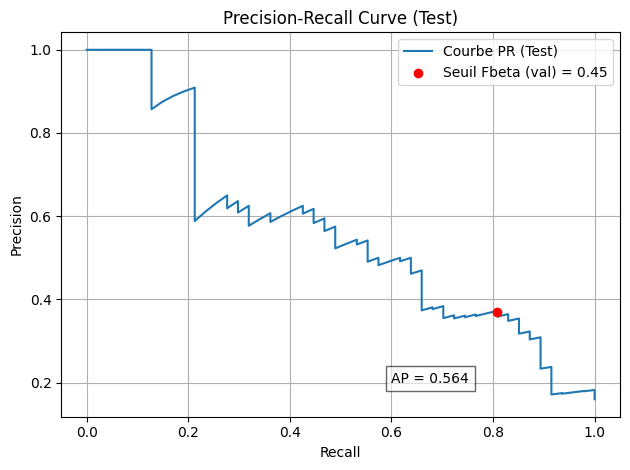

In [9]:
ap_test = average_precision_score(y_test, proba_test)   # PR AUC (Average Precision) — Test
print(f"PR AUC (Average Precision) — TEST : {ap_test:.3f}")
# Courbe PR (Test) pour visualiser + point au seuil optimal
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test)
# Point obtenu par application du seuil sur test
y_pred_custom = (proba_test >= best_thr).astype(int)
tp = ((y_test==1) & (y_pred_custom==1)).sum()
fp = ((y_test==0) & (y_pred_custom==1)).sum()
fn = ((y_test==1) & (y_pred_custom==0)).sum()
prec_pt = tp / (tp + fp)
rec_pt  = tp / (tp + fn)
plt.plot(recall_test, precision_test, label="Courbe PR (Test)")
plt.scatter(rec_pt, prec_pt, color="red", zorder=5, label=f"Seuil Fbeta (val) = {best_thr:.2f}")
plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
y_pred_test = (proba_test >= 0.5).astype(int)      # seuil classique
y_pred_custom = (proba_test >= best_thr).astype(int)  # seuil optimal choisi

print("=== balanced accuracy score - TEST (0.5) ===")
print(round(balanced_accuracy_score(y_test, y_pred_test), 3))
print(f"=== balanced accuracy score - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(round(balanced_accuracy_score(y_test, y_pred_custom), 3))

=== balanced accuracy score - TEST (0.5) ===
0.727
=== balanced accuracy score - TEST (seuil F2.0 VALIDATION) ===
0.773


#### On constate une amélioration du score de la balanced_accuracy en passant de 0.73 à 0.77.

In [11]:
# Prédictions sur TRAIN et TEST avec le pipeline déjà fit
y_pred_train = pipeline.predict(X_train) # afin de le faire apparaître dans ce notebook
y_pred_test  = pipeline.predict(X_test) # afin de le faire apparaître dans ce notebook

# Prédictions custom avec le seuil optimal (best_thr)
print("=== Classification Report - TEST (0.5) ===")
print(classification_report(y_test, y_pred_test, digits=3))
print(f"=== Classification Report — TEST (seuil F{beta:.1f} VALIDATION) ===")
print(classification_report(y_test, y_pred_custom, digits=3))

=== Classification Report - TEST (0.5) ===
              precision    recall  f1-score   support

           0      0.925     0.794     0.854       247
           1      0.378     0.660     0.481        47

    accuracy                          0.772       294
   macro avg      0.651     0.727     0.667       294
weighted avg      0.837     0.772     0.794       294

=== Classification Report — TEST (seuil F2.0 VALIDATION) ===
              precision    recall  f1-score   support

           0      0.953     0.737     0.831       247
           1      0.369     0.809     0.507        47

    accuracy                          0.748       294
   macro avg      0.661     0.773     0.669       294
weighted avg      0.860     0.748     0.779       294



#### Avec l'ajout du seuil optimal suite à notre modèle optimisé, on améliore les 2 scores intéressants pour nous, c'est à dire :
* Un meilleur recall de classe 0 en passant de 0.73 à 0.74 par rapport au test final de l'étape 4 avec fbeta
* Un meilleur recall de classe 1 en passant de 0.79 à 0.81 par rapport au test final de l'étape 4 avec fbeta

Nous avons aussi légèrement augmenté notre precision pour les 2 classes ainsi que le f1 score.

In [12]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST ===")
print(cm_test)

=== Matrice de confusion - TEST ===
[[196  51]
 [ 16  31]]


#### On voit avec la matrice de confusion que nous captons une bonne partie des départs des salariés. Le fait d'avoir mit l'accent sur le recall nous permet de pouvoir répondre au mieux à la mission que nous a confié les RH.

### Recommandation 2 : Commencez d’abord par la feature importance globale, moins complexe, avant de passer à la locale.

### Feature importance globale de notre modèle

In [13]:
# Récupération du modèle CatBoost à l'intérieur du pipeline
cat = best_model.named_steps['model']

# Récupération des noms de features après préprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Importances globales
importances = cat.get_feature_importance()

# Mettre en DataFrame pour plus de lisibilité
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(fi_df.head(15))  # top 15

                                           Feature  Importance
17                      cat__heure_supplementaires   15.761264
1                    num__annees_dans_l_entreprise   13.440082
0                              num__revenu_mensuel   11.142876
15                         num__pee_par_anciennete   10.928667
13                         num__score_satisfaction    8.886179
20                                cat__tranche_age    5.730605
18                      cat__frequence_deplacement    5.447663
3                  num__note_evaluation_precedente    4.268292
2         num__satisfaction_employee_environnement    3.139960
30                   cat__poste_DirecteurTechnique    2.791180
9                   num__distance_domicile_travail    2.273533
12                         num__experience_externe    2.093137
25                     cat__departement_Consulting    1.990517
6   num__satisfaction_employee_equilibre_pro_perso    1.796587
29                           cat__poste_Consultant    1

#### Graphique de la feature importance

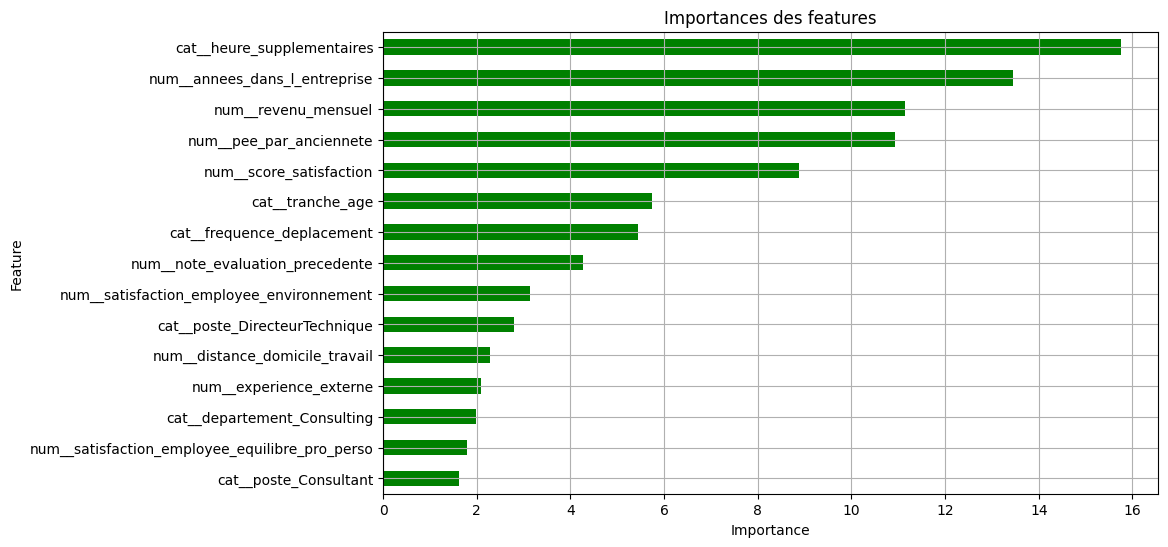

In [14]:
top_features = fi_df.nlargest(15, 'Importance')
top_features.sort_values(by="Importance", ascending=True).plot(
    x="Feature",
    y="Importance",
    kind="barh",
    legend=False,
    figsize=(10,6),
    color="green"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importances des features")
plt.grid()
plt.show()

On peut identifier 6 variables importantes et qui dominent les autres features :

- cat__heure_supplementaires
- num__annees_dans_l_entreprise
- num__revenu_mensuel
- num__pee_par_anciennete
- cat__tranche_age
- num__score_satisfaction

### Recommandation 3 : Comparez plusieurs méthodes de feature importance globale et analysez leur points de convergence et de divergence. Vous pouvez comparer à minima la Permutation Importance de sklearn avec le Beeswarm Plot du package SHAP. Si votre modèle optimisé est à base d’arbre, vous pouvez également inclure sa feature importance native dans la comparaison.

### Permutation importance

* La permutation importance va nous permettre également de mesurer l'importance des variables mais d'une façon un peu différente. Cette technique consiste à changer de manière aléatoire les données d'une variable pour en calculer son impact sur le modèle.

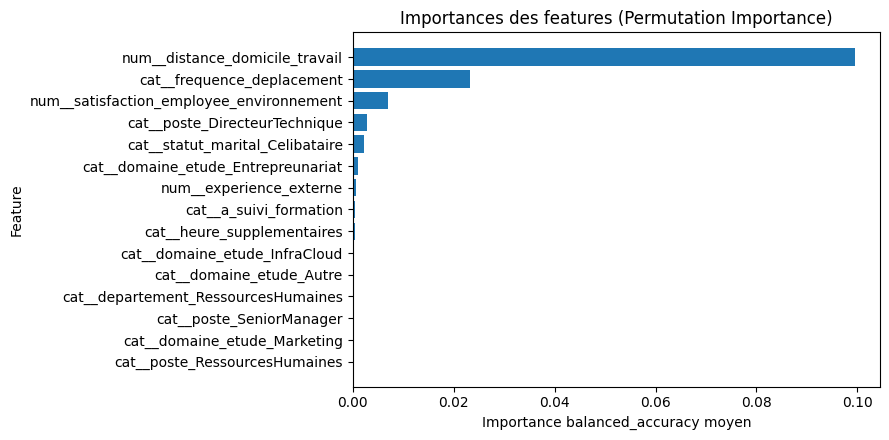


=== Permutation importance — Top 15 ===
                                 feature  importance_mean  importance_std
          num__distance_domicile_travail         0.099483        0.014509
              cat__frequence_deplacement         0.023301        0.026502
num__satisfaction_employee_environnement         0.006943        0.020969
           cat__poste_DirecteurTechnique         0.002942        0.008706
         cat__statut_marital_Celibataire         0.002227        0.001417
      cat__domaine_etude_Entrepreunariat         0.001012        0.001012
                 num__experience_externe         0.000607        0.001296
                  cat__a_suivi_formation         0.000405        0.000810
              cat__heure_supplementaires         0.000405        0.000810
           cat__domaine_etude_InfraCloud         0.000202        0.000607
                cat__domaine_etude_Autre         0.000202        0.000607
     cat__departement_RessourcesHumaines         0.000202        0.0006

In [15]:
# Ajout de la permutation_importance
perm = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring='balanced_accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
# Création d'un DataFrame des importances
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
perm_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
)
# Top 15 pour lisibilité
topk = 15
top_df = perm_df.head(topk).iloc[::-1] 

# Graphique
plt.figure(figsize=(9, 4.5))
plt.barh(top_df['feature'], top_df['importance_mean'])
plt.title("Importances des features (Permutation Importance)")
plt.xlabel("Importance balanced_accuracy moyen") 
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Afficher le tableau Top 15
print("\n=== Permutation importance — Top 15 ===")
print(top_df.iloc[::-1].to_string(index=False)) 

* Concentration de la permutation importance (avec comme scoring la balanced_accuracy) dans la varibale num__distance_domicile_travail et dans une moindre mesure dans le cat__frequence_deplacement

### Recommandation 4 : Si vous utilisez un modèle à base d’arbre, privilégiez l’utilisation du TreeExplainer du package SHAP. Sinon, vous pouvez utiliser le KernelExplainer, plus généraliste.

### Continuons l'analyse de manière globale avec le Beeswarm de l'analyse de SHAP

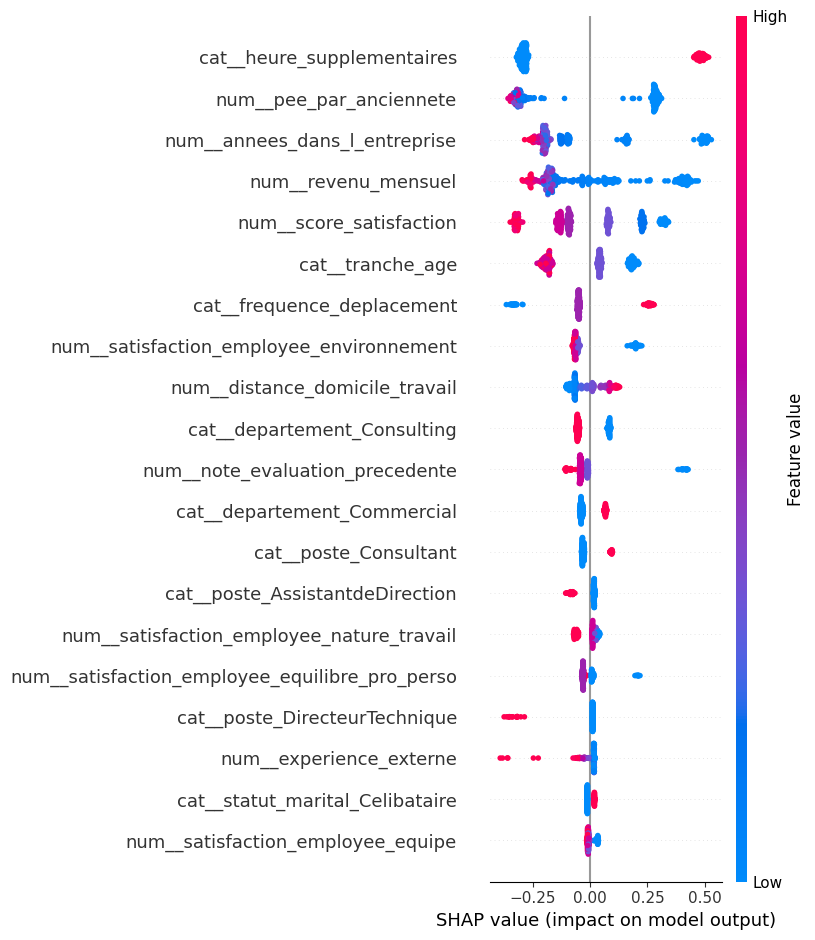

In [16]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Graphique de beeswarm
shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


#### On peut noter ici plusieurs choses intéressantes :
* On voit que les salariés avec un revenu mensuel bas ont une plus grande probabilité de partir alors que les salaires les plus hauts ont une probabilité plus faible de départ. Notre intuition dans les étapes précédentes suit cette logique.
* On voit que les salariés qui réalisent des heures supplémentaires ont une probabilité plus grande de partir que ceux qui n'en font pas.
* Plus de probabilité de départ pour des personnes arrivées il n'y a pas longtemps dans l'entreprise. Ce qui explique également le nombre de PEE plus faible qui indique un score de proba vers le départ.
* Plus de départs possibles dans une tranche d'âge plus jeune

### Recommandation 5 : Assurez-vous de bien comprendre le sens des Shapley values en utilisant la fonction shap.plots.scatter() et son argument “color”.

#### Pour la variable revenu_mensuel

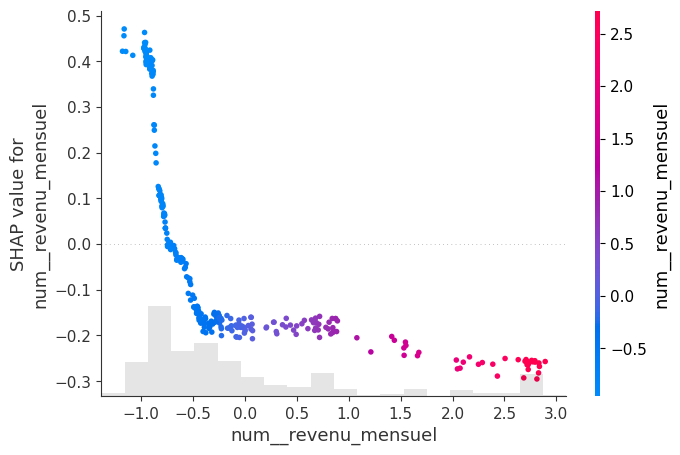

In [17]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__revenu_mensuel"],
    color=sv[:, "num__revenu_mensuel"]
)

L’analyse SHAP de la variable revenu_mensuel montre que les bas salaires sont fortement associés à une augmentation du risque de démission, alors que les salaires élevés tendent au contraire à réduire ce risque. Cette relation est cohérente avec une intuition métier, une meilleure rémunération peut limiter le turnover, alors qu’une rémunération trop faible peut pousser au départ.

#### Pour la variable années dans l'entreprise

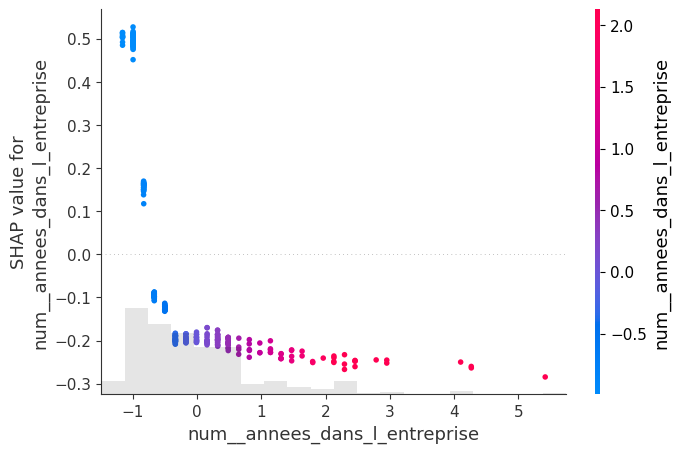

In [18]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__annees_dans_l_entreprise"],
    color=sv[:, "num__annees_dans_l_entreprise"]
)

On voit une probabilité plus forte de départs pour ceux qui ont le moins d'ancienneté dans l'entreprise alors que les plus anciens ont plus de probabilité à rester.

### Recommandation 6 : Pour la feature importance locale, utilisez le Waterfall Plot. Choisissez quelques exemples issus des 2 classes.

### Attaquons nous à la feature locale
#### L'idée ici va être de regarder le comportement des features au cas par cas. Regardons plusieurs exemples.

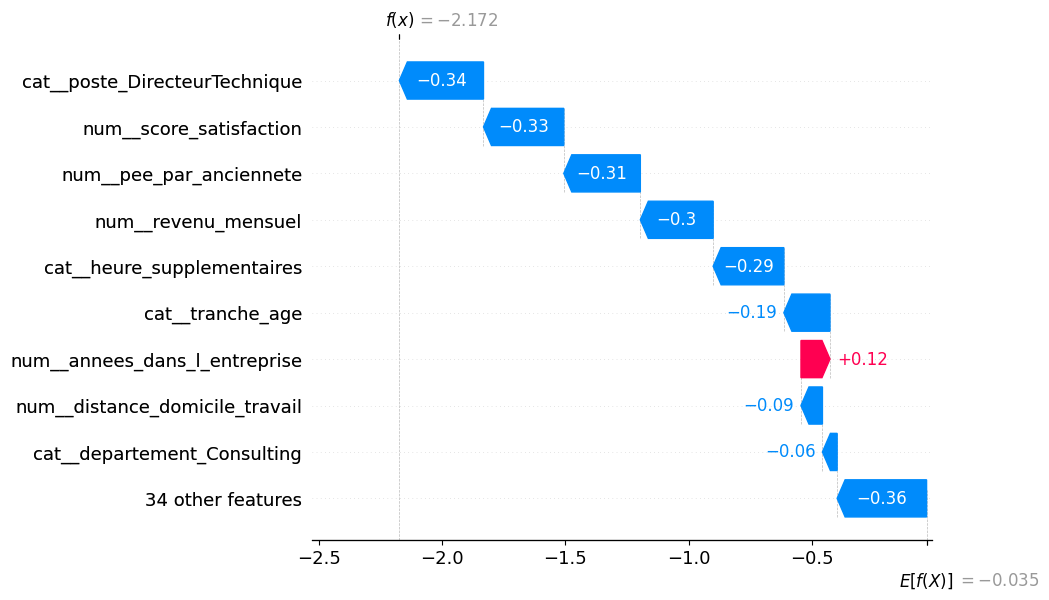

In [19]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 1er individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[100],
    feature_names=feature_names
)

Globalement, la majorité des variables tirent vers le bas (réduisent le risque).

* cat__poste_DirecteurTechnique : contribution –0.34. Ce poste réduit fortement la probabilité de quitter l’entreprise.
* num__score_satisfaction : –0.33 : une satisfaction élevée baisse le risque de départ.
* num__revenu_mensuel : –0.30 : un revenu plus haut baisse aussi le risque.
* num__annees_dans_l_entreprise : +0.12 (en rouge) : ici, l’ancienneté augmente la probabilité de départ.
* Les autres features (cat__heure_supplementaires, num__distance_domicile_travail, etc.) ont des effets plus petits mais vont globalement dans le sens d’un risque plus faible.

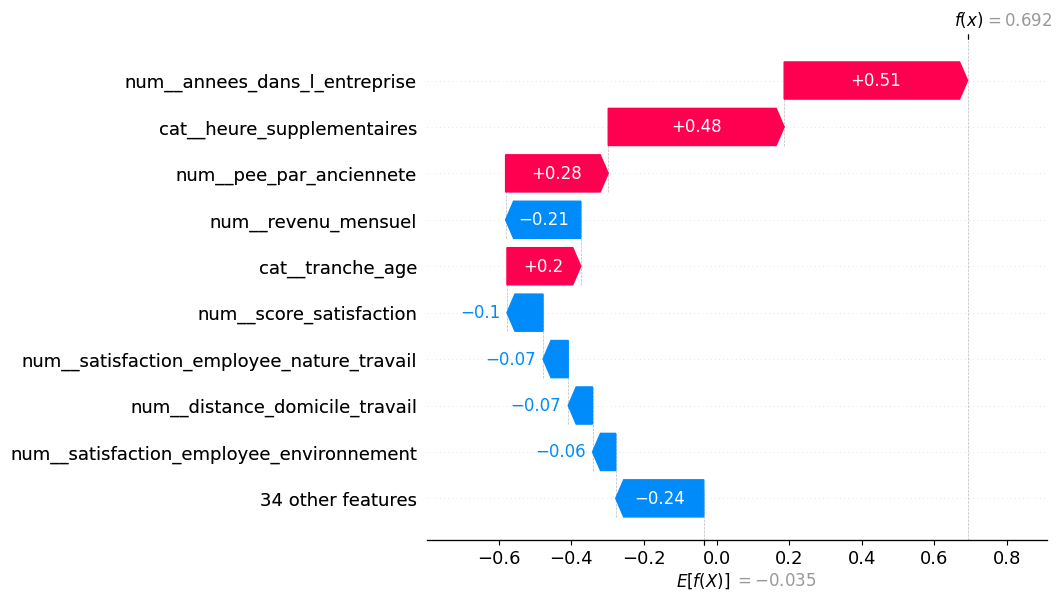

In [20]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 17ième individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[18],
    feature_names=feature_names
)

La probabilité de base est de -0.035 et elle passe à 0.692 avec les features pour ce salarié.
* Les features déterminantes quant à son départ sont les heures supplémentaires, le nombre d'années dans l'entreprise, le PEE et la tranche d'âge. Par contre dans ce cas précis le revenu mensuel pousse le modèle vers le bas.